In [ ]:
!pip install --upgrade torch fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Authenticate Colab to use my Google Drive for data storage and retrieval
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'BreastCancer'

Mounted at /content/gdrive


In [ ]:
!find /content/gdrive/My\ Drive/BreastCancer -maxdepth 1 -type d | wc -l

2


In [ ]:
%cd /content/gdrive/My\ Drive/BreastCancer

/content/gdrive/My Drive/BreastCancer


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
# Define image transformations
from fastai.vision.all import *
tfms = aug_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.3, max_warp=0.3,
                      max_rotate=20., max_zoom=0.05)
len(tfms)

2

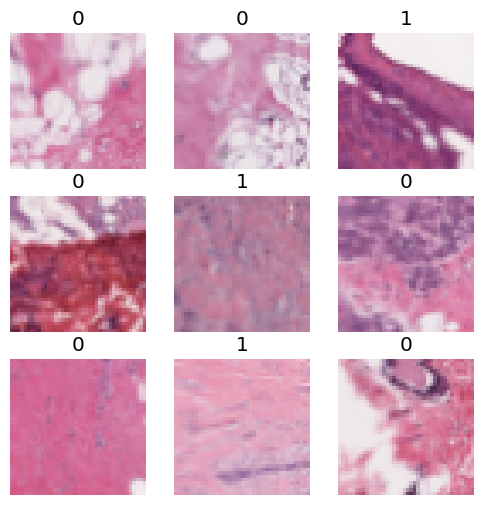

In [ ]:
path = '/content/gdrive/My Drive/BreastCancer/IDC_regular_ps50_idx5/'
dls = ImageDataLoaders.from_folder(path,
                                   valid_pct=0.2,
                                   item_tfms=Resize(40),  # Resize images to 48x48
                                   batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
                                   bs=128)  # Batch size

dls.show_batch(max_n=9, figsize=(6,6))

In [ ]:
print(len(dls.train_ds))  # Number of training samples
print(len(dls.valid_ds))  # Number of validation samples

66504
16626


In [ ]:
# Get all validation labels
valid_labels = [dls.valid_ds[i][1] for i in range(len(dls.valid_ds))]

# Count occurrences of each label
valid_counts = Counter(valid_labels)

# Show most common labels
print(valid_counts.most_common())

KeyboardInterrupt: 

In [ ]:
import torch
weights = [0.4, 1]
class_weights = torch.FloatTensor(weights)  # Remove .cuda()

In [ ]:
# Begin the training
learn = cnn_learner(dls, models.efficientnet_b0, metrics=[accuracy]).to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
learn.fit_one_cycle(5);

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hu

epoch,train_loss,valid_loss,accuracy,time
0,0.599062,0.511711,0.742752,2:27:51
1,0.481721,0.453852,0.780885,20:01
2,0.451244,0.429158,0.796824,20:13
3,0.436490,0.414337,0.811139,19:47
4,0.436061,0.413573,0.807711,19:58


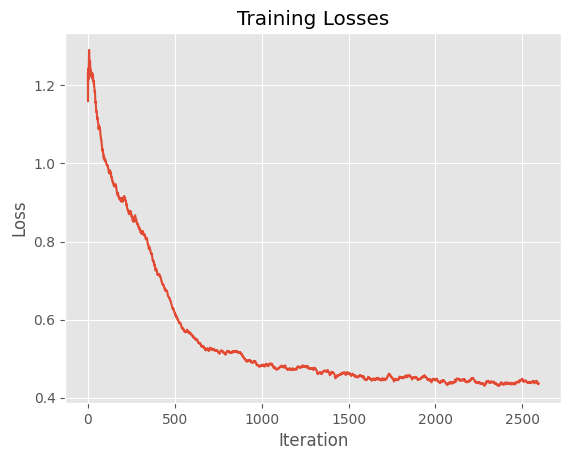

In [ ]:
import matplotlib.pyplot as plt

# Get training losses
train_losses = learn.recorder.losses

# Plot the losses
plt.plot(train_losses)
plt.title("Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Saving the model
learn.save('stage-1-rn50')

Path('/content/gdrive/My Drive/BreastCancer/IDC_regular_ps50_idx5/models/stage-1-rn50.pth')

In [ ]:
# Model's final validation loss and accuracy
learn.validate()

(#2) [0.41357314586639404,0.8077108263969421]

In [ ]:
# Model's final training loss and accuracy on the validation set
learn.validate(dl=learn.dls.valid)

(#2) [0.41357314586639404,0.8077108263969421]

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
# Get the number of available losses
len(losses)

16626

In [ ]:
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")


Training samples: 66504
Validation samples: 16626


In [ ]:
results = learn.get_preds(dl=dls.valid, with_decoded=True)
print(len(results))  # Check how many items are being returned

# Unpack correctly
if len(results) == 2:
    preds, targs = results
elif len(results) == 3:  # Sometimes it returns (preds, targs, loss values)
    preds, targs, _ = results
else:
    raise ValueError(f"Unexpected number of return values: {len(results)}")

print(len(preds), len(targs))


3
16626 16626


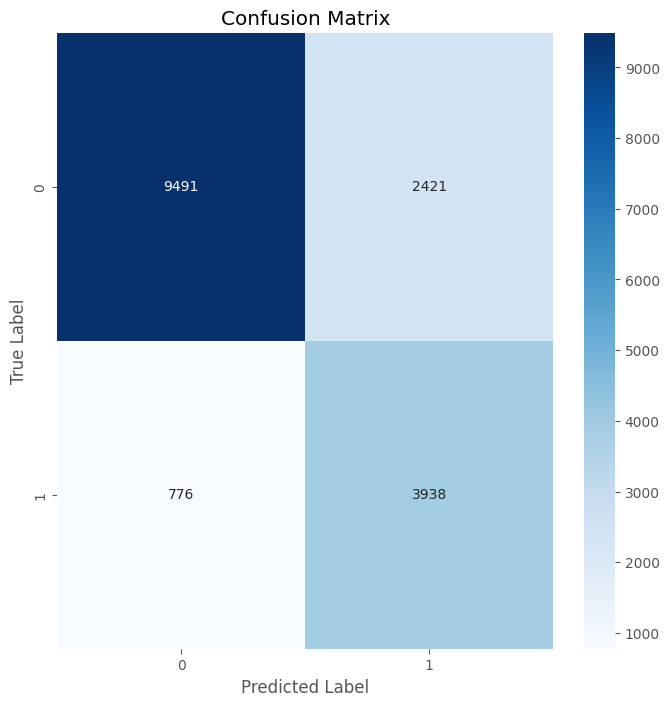

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert tensors to numpy arrays
y_true = targs.numpy()
y_pred = preds.argmax(dim=1).numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    # Get predictions from the validation set
    results = learn.get_preds(dl=learn.dls.valid, with_decoded=True)

    # Check the number of returned values
    if len(results) == 2:
        preds, targs = results  # Expected case
    elif len(results) == 3:
        preds, targs, _ = results  # Handle extra returned loss values
    else:
        raise ValueError(f"Unexpected number of return values: {len(results)}")

    # Convert tensor predictions to class labels
    vocab = learn.dls.vocab  # Get class names
    pred_labels = [vocab[p] for p in preds.argmax(dim=1).numpy()]
    ground_truth = [vocab[t] for t in targs.numpy()]

    assert len(pred_labels) == len(ground_truth)

    return classification_report(ground_truth, pred_labels, target_names=vocab)

# Print classification report
print(return_classification_report(learn))


              precision    recall  f1-score   support

           0       0.92      0.80      0.86     11912
           1       0.62      0.84      0.71      4714

    accuracy                           0.81     16626
   macro avg       0.77      0.82      0.78     16626
weighted avg       0.84      0.81      0.81     16626



In [ ]:
print(type(learn))


<class 'fastai.learner.Learner'>


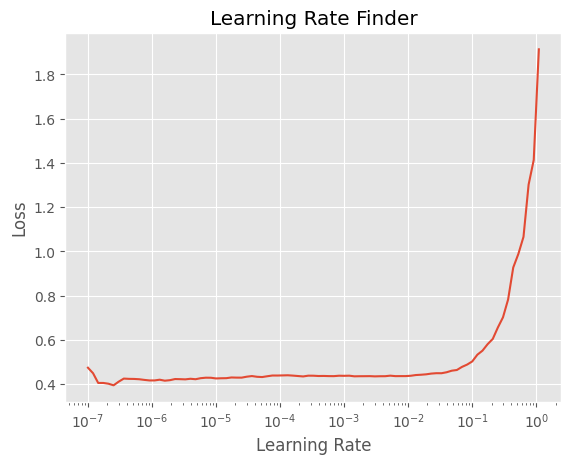

In [ ]:
import matplotlib.pyplot as plt

lrs = learn.recorder.lrs
losses = learn.recorder.losses

plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-4, 1e-5))


epoch,train_loss,valid_loss,accuracy,time
0,0.420868,0.384715,0.817515,30:26
1,0.389495,0.383547,0.813786,30:25


In [ ]:
# Save model
learn.save('stage-2-more-rn50')

Path('/content/gdrive/My Drive/BreastCancer/IDC_regular_ps50_idx5/models/stage-2-more-rn50.pth')

In [ ]:
# Looking at the classification report
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     11912
           1       0.62      0.89      0.73      4714

    accuracy                           0.81     16626
   macro avg       0.78      0.84      0.79     16626
weighted avg       0.85      0.81      0.82     16626



In [ ]:
learn.summary()

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Sequential (Input shape: 128 x 3 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 20 x 20  
Conv2d                                    864        True      
BatchNorm2d                               64         True      
SiLU                                                           
Conv2d                                    288        True      
BatchNorm2d                               64         True      
SiLU                                                           
____________________________________________________________________________
                     128 x 32 x 1 x 1    
AdaptiveAvgPool2d                                              
____________________________________________________________________________
                     128 x 8 x 1 x 1     
Conv2d                                    264        True      
____________________________________________________________________________
                     12

In [ ]:
# Export the model in pickle format
learn.export('breast-cancer-rn50.pkl')